In [8]:
import time
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
import torch.nn.functional as F
import torchvision
import os,json
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchvision.__version__)
print(device)

1.7.1+cu110
0.8.2+cu110
cuda:0


In [9]:
Batch = 16

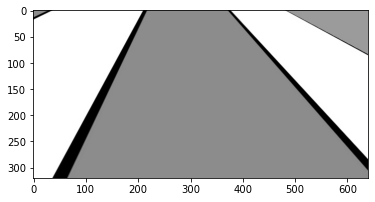

In [11]:
class MyDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1), # 彩色图像转灰度图像num_output_channels默认1
        transforms.ToTensor()
    ])

        
        self.images = []
        self.labels = []
        self.transform = transform
        for i in range(6290):
            self.images.append( 'img/'+ str(i) + '.jpg')
            file = open( 'label/'+  str(i) + '.json','r')
            a = json.load(file)
            l = [a['z']]
#             l = [a['z']]
            l = torch.Tensor(l)
            self.labels.append(l)
            
            file.close()
 
    def __len__(self):
        # 返回数据集的数据数量
        return len(self.images)
 
    def __getitem__(self, index):
        img_path = self.images[index]
        label = self.labels[index]
        label = torch.unsqueeze(label, dim=0)  
        img0 = cv2.imread(img_path)
        img = cv2.cvtColor(img0[160: :], cv2.COLOR_BGR2RGB)
        #img = torch.Tensor(img)
        #img = torch.unsqueeze(img, dim=0)
        img = torch.from_numpy(img).permute(2, 0, 1)/255
#         img = Image.fromarray(img)
#         img = transform(img)
        
        sample = {'image': img, 'label': label}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample
    
img0 = cv2.imread('img/1111.jpg')
img = cv2.cvtColor(img0[160: :], cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [12]:
train_dataset = MyDataset()
dataloader = DataLoader(train_dataset, batch_size=Batch, shuffle=True)
# for index, batch_data in enumerate(dataloader):
#         print(index, batch_data['image'].shape, batch_data['label'].shape)

In [13]:
net = models.alexnet()
net.classifier._modules['7'] = nn.Sequential(nn.ReLU(),nn.Dropout(0.5),nn.Linear(1000, 1))

#net.classifier[6] = nn.Linear(4096,2)
#net.add(nn.Linear(1000,2))
print(net)

#print(net.conv1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
def train(model, train_batch, batch_size, optimizer, device, num_epochs):
    model = model.to(device)
    print("run in " , device)
 
    # 损失函数,MSE函数
    loss = torch.nn.MSELoss()
 
    for epoch in range(num_epochs):
        train_loss_sum, train_rmse_sum, n, batch_count = 0.0, 0.0, 0, 0
        start = time.time()
 
        for X, y in enumerate(train_batch):
            # 转置
            X = y['image']
            y = y['label']
            X = X.to(device)
#             print(X.size(),y.size())
            y = y.to(device)
 
 
            # 前向计算
            
            y_pre = model(X)
            y = torch.sum(y,dim=1)
#             print(y_pre.size())
#             print(y.size())
 
            l = loss(y_pre, y)
 
            # 梯度清零
            optimizer.zero_grad()
 
            l.backward()
            optimizer.step()
 
            train_loss_sum += l.cpu().item()
            train_rmse_sum += torch.sqrt(((y_pre-y)**2).sum()).cpu().item()
            n += y.shape[0]
            batch_count += 1
 
        print("epoch:%d, loss:%.4f, train_rmse:%.3f,  cost: %.1f sec" %
              (epoch + 1, train_loss_sum / batch_count, train_rmse_sum / n, time.time() - start))


In [15]:

lr = 0.0002

optimizer = torch.optim.Adam(net.parameters(),lr = lr)
num_epochs = 300
train(net, dataloader, Batch, optimizer, device, num_epochs)

run in  cuda:0


KeyboardInterrupt: 

In [ ]:
#train(net, dataloader, Batch, optimizer, device, 50)

In [ ]:
#train(net, dataloader, Batch, optimizer, device, 150)

In [ ]:
save_path = 'twouse.pt'
torch.save(net.state_dict(), save_path)

In [ ]:
net.eval()
def pre(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img[155: :], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    img = torch.from_numpy(img).permute(2, 0, 1)/255
    img = torch.Tensor(img)
    img = torch.unsqueeze(img, dim=0)  
    
    img = img.to(device)
    output = model(img)
    #output = torch.sum(output,dim=1)
    
    #_, predicted = torch.max(output, 1)
    return output
print(pre(net,'img/1999.jpg'))

In [ ]:
model = models.alexnet()
model.classifier._modules['7'] = nn.Sequential(nn.ReLU(),nn.Dropout(0.5),nn.Linear(1000, 1))


model.load_state_dict(torch.load(save_path))
model.eval()
model = model.to(device)


In [ ]:
def predict(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img[160: :], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    img = torch.from_numpy(img).permute(2, 0, 1)/255
    img = torch.Tensor(img)
    img = torch.unsqueeze(img, dim=0)  
    
    img = img.to(device)
    output = model(img)
    #output = torch.sum(output,dim=1)
    print(output.size())
    #_, predicted = torch.max(output, 1)
    return output

print(predict(model,'img/2222.jpg'))
